In [7]:
# Importing necessary libraries
import os
import zipfile

# Extracting the contents of the ZIP file
audio_dataset_path = '/content/audio_dataset'
with zipfile.ZipFile('/content/dataset.zip', 'r') as zip_ref:
    zip_ref.extractall(audio_dataset_path)

# Listing the directories (cats and dogs) and the number of audio files in each
directories = [dir_name for dir_name in os.listdir(audio_dataset_path) if os.path.isdir(os.path.join(audio_dataset_path, dir_name))]
file_counts = {dir_name: len(os.listdir(os.path.join(audio_dataset_path, dir_name))) for dir_name in directories}

directories, file_counts


(['__MACOSX', 'dataset'], {'__MACOSX': 1, 'dataset': 2})

In [8]:
# Exploring within the 'dataset' directory
dataset_path = os.path.join(audio_dataset_path, 'dataset')
subdirectories = [dir_name for dir_name in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, dir_name))]

# Counting the number of audio files in each subdirectory
subdir_file_counts = {dir_name: len(os.listdir(os.path.join(dataset_path, dir_name))) for dir_name in subdirectories}

subdir_file_counts


{'dogs': 28, 'cats': 39}

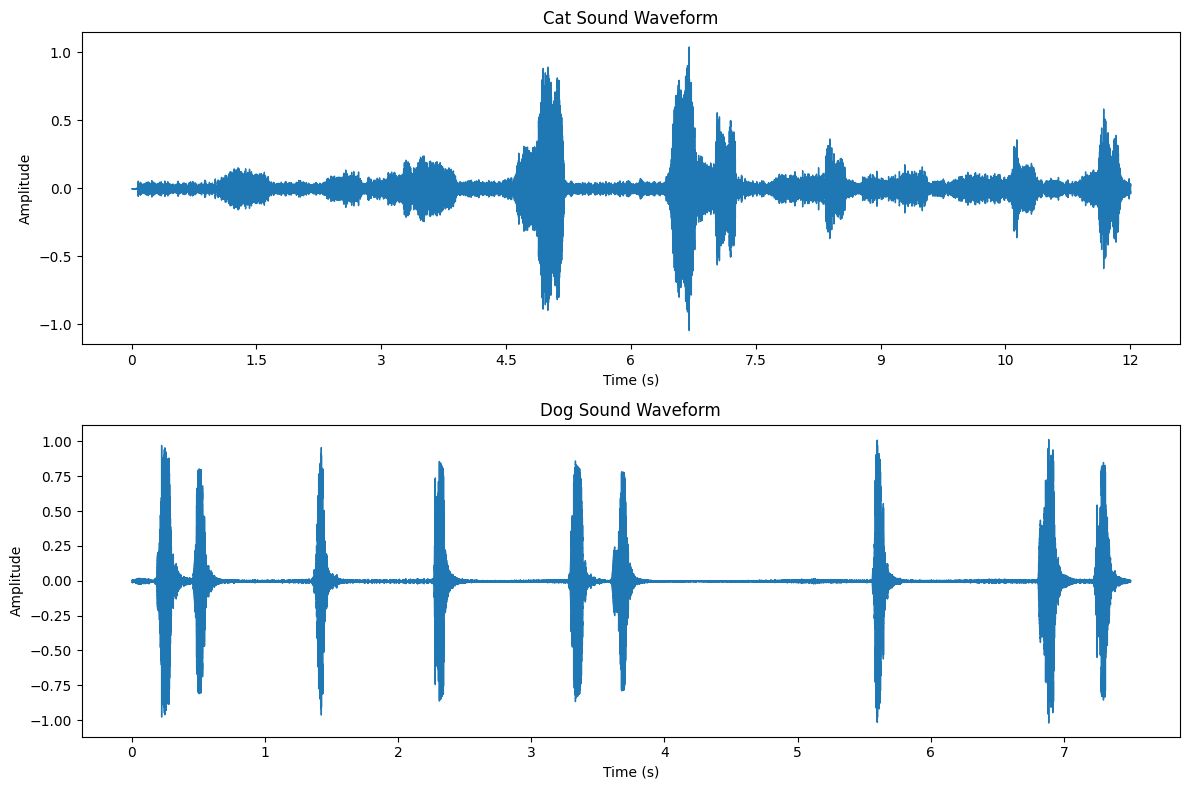

In [9]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Loading a sample audio file for each category
sample_cat_file = os.path.join(dataset_path, 'cats', os.listdir(os.path.join(dataset_path, 'cats'))[0])
sample_dog_file = os.path.join(dataset_path, 'dogs', os.listdir(os.path.join(dataset_path, 'dogs'))[0])

# Using librosa to load the audio files and get the waveforms
cat_waveform, sr_cat = librosa.load(sample_cat_file)
dog_waveform, sr_dog = librosa.load(sample_dog_file)

# Plotting the waveforms
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
librosa.display.waveshow(cat_waveform, sr=sr_cat)
plt.title('Cat Sound Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
librosa.display.waveshow(dog_waveform, sr=sr_dog)
plt.title('Dog Sound Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


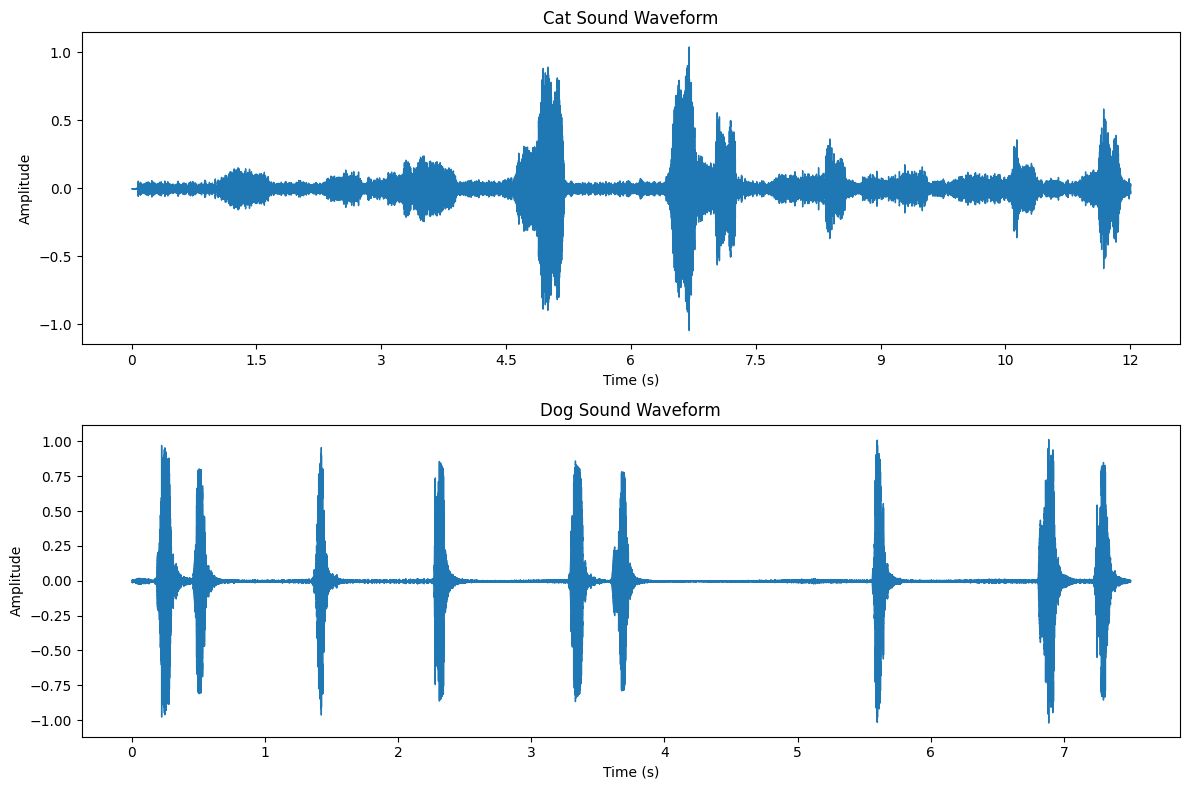

In [10]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load the audio files
cat_waveform, sr_cat = librosa.load(sample_cat_file)
dog_waveform, sr_dog = librosa.load(sample_dog_file)

# Plot the waveforms
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
librosa.display.waveshow(cat_waveform, sr=sr_cat)
plt.title('Cat Sound Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
librosa.display.waveshow(dog_waveform, sr=sr_dog)
plt.title('Dog Sound Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


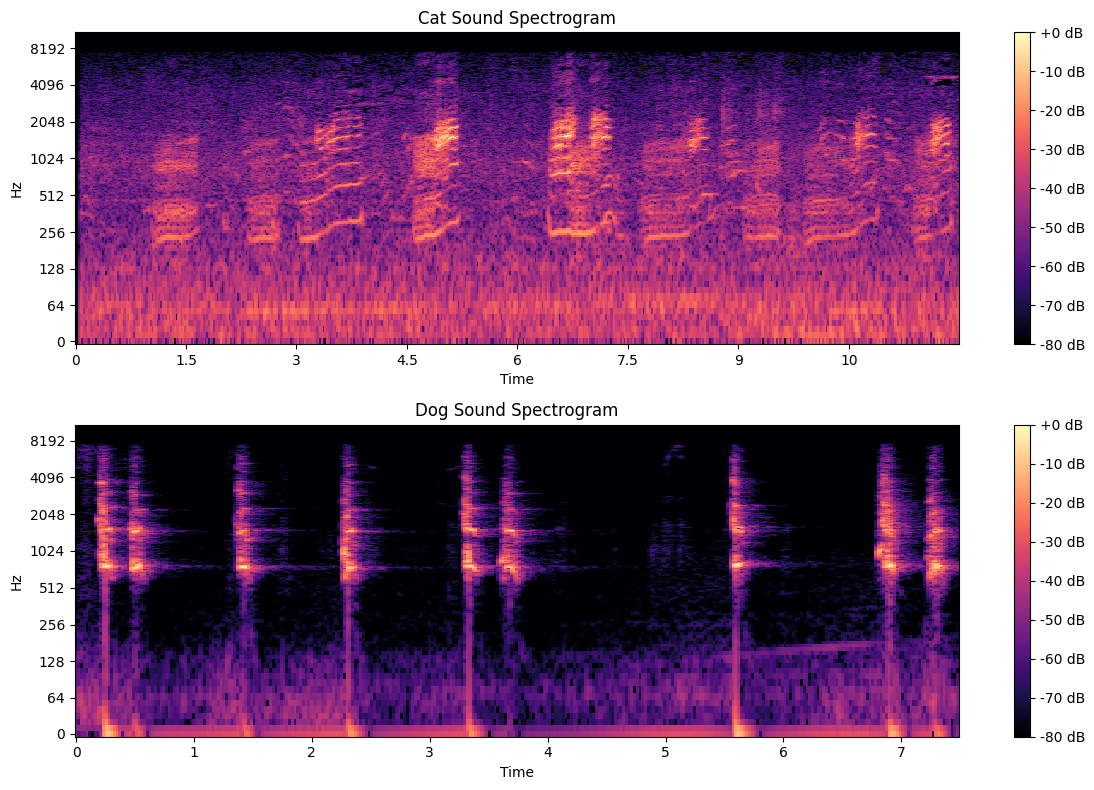

In [12]:
import numpy as np

# Convert the waveform to a spectrogram
D_cat = librosa.amplitude_to_db(np.abs(librosa.stft(cat_waveform)), ref=np.max)
D_dog = librosa.amplitude_to_db(np.abs(librosa.stft(dog_waveform)), ref=np.max)

# Plot the spectrograms
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
librosa.display.specshow(D_cat, sr=sr_cat, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Cat Sound Spectrogram')

plt.subplot(2, 1, 2)
librosa.display.specshow(D_dog, sr=sr_dog, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Dog Sound Spectrogram')

plt.tight_layout()
plt.show()


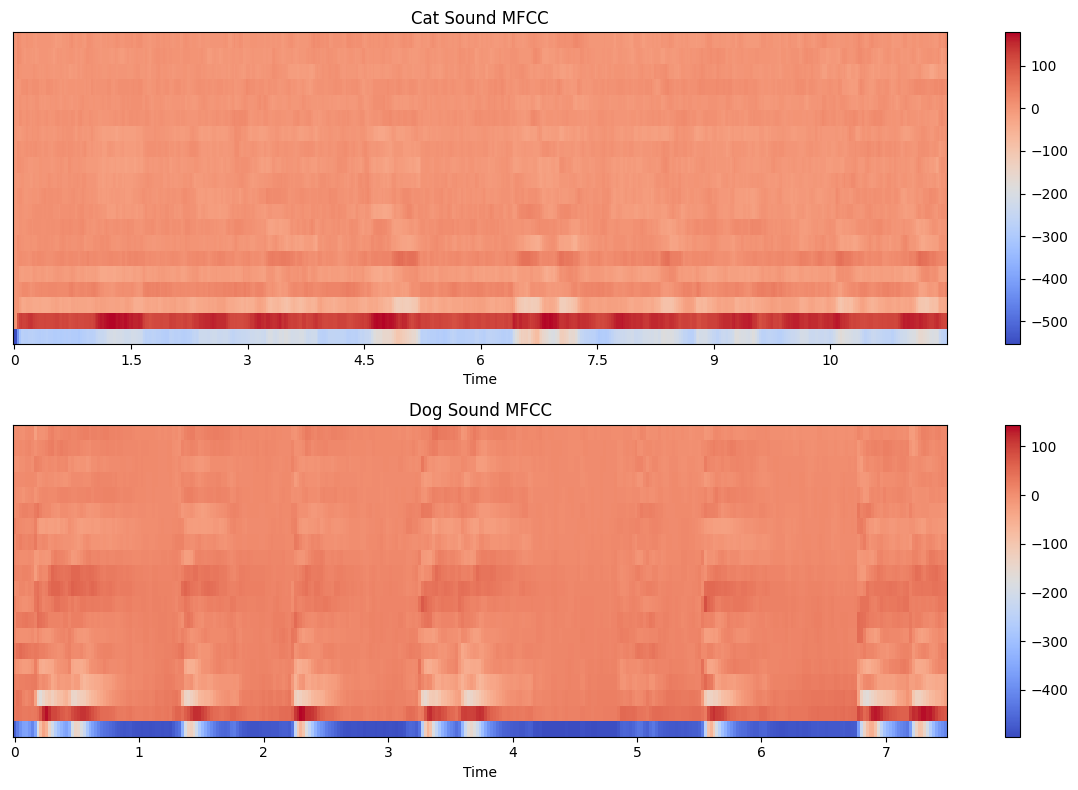

In [15]:
# Extracting MFCCs
mfccs_cat = librosa.feature.mfcc(y=cat_waveform, sr=sr_cat)
mfccs_dog = librosa.feature.mfcc(y=dog_waveform, sr=sr_dog)

# Plotting MFCCs
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
librosa.display.specshow(mfccs_cat, sr=sr_cat, x_axis='time')
plt.colorbar()
plt.title('Cat Sound MFCC')

plt.subplot(2, 1, 2)
librosa.display.specshow(mfccs_dog, sr=sr_dog, x_axis='time')
plt.colorbar()
plt.title('Dog Sound MFCC')

plt.tight_layout()
plt.show()


In [16]:
desired_sample_rate = 22050

def resample_audio(file_path, desired_sample_rate):
    y, sr = librosa.load(file_path, sr=desired_sample_rate)
    return y, sr


In [17]:
desired_duration = 5  # 5 seconds, for example

def adjust_audio_length(y, sr, desired_duration):
    audio_duration = librosa.get_duration(y, sr)

    if audio_duration < desired_duration:
        # If the audio is shorter, pad with zeros
        padding = int((desired_duration * sr) - len(y))
        y_padded = np.pad(y, (0, padding), 'constant')
        return y_padded
    elif audio_duration > desired_duration:
        # If the audio is longer, trim it
        y_trimmed = y[:int(desired_duration * sr)]
        return y_trimmed
    else:
        return y


In [18]:
def remove_silence(y, sr, threshold=0.01, frame_length=2048, hop_length=512):
    # Compute the short-time energy of the audio signal
    energy = librosa.feature.rmse(y=y, frame_length=frame_length, hop_length=hop_length)

    # Find frames that have energy above the threshold
    frames = np.nonzero(energy > threshold)[0]

    # Construct the trimmed audio
    y_trimmed = librosa.frames_to_samples(frames, hop_length=hop_length)

    return y[y_trimmed]


In [19]:
def scale_audio(y):
    return y / np.max(np.abs(y))


In [32]:
def aggregate_features(mfccs, chroma, spec_contrast):
    features = {}

    # Aggregating MFCCs
    features['mfcc_mean'] = np.mean(mfccs, axis=1)
    features['mfcc_std'] = np.std(mfccs, axis=1)

    # Aggregating Chroma Features
    features['chroma_mean'] = np.mean(chroma, axis=1)
    features['chroma_std'] = np.std(chroma, axis=1)

    # Aggregating Spectral Contrast
    features['spec_contrast_mean'] = np.mean(spec_contrast, axis=1)
    features['spec_contrast_std'] = np.std(spec_contrast, axis=1)

    # Flatten the resulting dictionary values into a single list
    flattened_features = []
    for key, value in features.items():
        flattened_features.extend(value)

    return flattened_features


In [34]:
def extract_features(audio_file):
    y, sr = librosa.load(audio_file)

    # Extracting MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr)

    # Extracting Chroma Feature
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)

    # Extracting Spectral Contrast
    spec_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

    return mfccs, chroma, spec_contrast


In [35]:
def aggregate_features(mfccs, chroma, spec_contrast):
    features = {}

    # Aggregating MFCCs
    features['mfcc_mean'] = np.mean(mfccs, axis=1)
    features['mfcc_std'] = np.std(mfccs, axis=1)

    # Aggregating Chroma Features
    features['chroma_mean'] = np.mean(chroma, axis=1)
    features['chroma_std'] = np.std(chroma, axis=1)

    # Aggregating Spectral Contrast
    features['spec_contrast_mean'] = np.mean(spec_contrast, axis=1)
    features['spec_contrast_std'] = np.std(spec_contrast, axis=1)

    return features


In [36]:
from sklearn.model_selection import train_test_split

# Lists to store features and labels
all_features = []
all_labels = []

# Feature extraction for all audio files
for subdir in ['cats', 'dogs']:
    for file in os.listdir(os.path.join(dataset_path, subdir)):
        audio_file = os.path.join(dataset_path, subdir, file)

        mfccs, chroma, spec_contrast = extract_features(audio_file)
        features = aggregate_features(mfccs, chroma, spec_contrast)

        all_features.append(features)
        all_labels.append(subdir)

# Convert features to an appropriate format suitable for ML models (e.g., DataFrame or numpy array)
X = np.array(all_features)
y = np.array(all_labels)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [38]:
print(X_train.shape)
print(X_test.shape)


(53, 6)
(14, 6)


In [39]:
# Check the first few rows to see if they contain any nested sequences
for index, row in X_train.head().iterrows():
    for item in row:
        if isinstance(item, (list, np.ndarray)):
            print(f"Found a nested sequence in row {index}.")


Found a nested sequence in row 26.
Found a nested sequence in row 26.
Found a nested sequence in row 26.
Found a nested sequence in row 26.
Found a nested sequence in row 26.
Found a nested sequence in row 26.
Found a nested sequence in row 54.
Found a nested sequence in row 54.
Found a nested sequence in row 54.
Found a nested sequence in row 54.
Found a nested sequence in row 54.
Found a nested sequence in row 54.
Found a nested sequence in row 48.
Found a nested sequence in row 48.
Found a nested sequence in row 48.
Found a nested sequence in row 48.
Found a nested sequence in row 48.
Found a nested sequence in row 48.
Found a nested sequence in row 23.
Found a nested sequence in row 23.
Found a nested sequence in row 23.
Found a nested sequence in row 23.
Found a nested sequence in row 23.
Found a nested sequence in row 23.
Found a nested sequence in row 57.
Found a nested sequence in row 57.
Found a nested sequence in row 57.
Found a nested sequence in row 57.
Found a nested seque

In [40]:
# Print types of the first few rows of X_train
for index, row in X_train.head().iterrows():
    print([type(item) for item in row])


[<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]
[<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]
[<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]
[<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]
[<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]


In [41]:
# Check for nested structures within the first few rows of X_train
for index, row in X_train.head().iterrows():
    for item in row:
        if isinstance(item, (list, np.ndarray)):
            print(f"Found a nested sequence in row {index}: {item}")


Found a nested sequence in row 26: [-277.4863      106.558075     -5.063034     16.276915     -3.6953354
   11.194166     -5.242244      1.8115482     7.031087     -3.1028593
   -3.8609107     2.4875104     9.449049     16.335472     19.342733
    4.8395376     0.63202643   -6.252314      1.2019558     4.3267946 ]
Found a nested sequence in row 26: [125.36739    26.14651    58.753082   21.021776   32.39331    13.1107025
  12.497397   12.17046    15.794234    9.358012    6.3950644  13.92788
  11.907567   13.13679    16.688698   12.269995   12.057766   11.604211
   9.294002    5.561875 ]
Found a nested sequence in row 26: [0.6063206  0.5778187  0.31982833 0.27334496 0.25074038 0.24046332
 0.2430941  0.29623958 0.46596462 0.39093792 0.443516   0.5088475 ]
Found a nested sequence in row 26: [0.35943273 0.3239539  0.28650177 0.32096753 0.29224637 0.26842535
 0.2732558  0.27021435 0.34665635 0.33667952 0.3749436  0.3672563 ]
Found a nested sequence in row 26: [23.66367915 12.21002565 19.8437

In [42]:
def aggregate_features(mfccs, chroma, spec_contrast):
    features = {}

    # Aggregating MFCCs
    features['mfcc_mean'] = np.mean(mfccs)
    features['mfcc_std'] = np.std(mfccs)
    features['mfcc_max'] = np.max(mfccs)
    features['mfcc_min'] = np.min(mfccs)

    # Aggregating Chroma Features
    features['chroma_mean'] = np.mean(chroma)
    features['chroma_std'] = np.std(chroma)
    features['chroma_max'] = np.max(chroma)
    features['chroma_min'] = np.min(chroma)

    # Aggregating Spectral Contrast
    features['spec_contrast_mean'] = np.mean(spec_contrast)
    features['spec_contrast_std'] = np.std(spec_contrast)
    features['spec_contrast_max'] = np.max(spec_contrast)
    features['spec_contrast_min'] = np.min(spec_contrast)

    # Convert the dictionary into a pandas series
    feature_series = pd.Series(features)

    return feature_series


In [44]:
!pip install tqdm

In [52]:
import os

# Path to the dataset
dataset_path = "/content/audio_dataset/dataset"  # Replace this with your path

# Retrieve all audio files
all_files = []
categories = ['cats', 'dogs']  # Assuming you have two folders named 'cat' and 'dog'

for category in categories:
    cat_files = [os.path.join(dataset_path, category, file) for file in os.listdir(os.path.join(dataset_path, category)) if file.endswith('.wav')]
    all_files.extend(cat_files)

# Now you can use the all_files list


In [53]:
# Extracting and aggregating features
feature_list = []
for file in all_files:
    y, sr = librosa.load(file, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    spec_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

    aggregated_features = aggregate_features(mfccs, chroma, spec_contrast)
    feature_list.append(aggregated_features)

# Convert the list of aggregated features into a DataFrame
df_features = pd.DataFrame(feature_list)


/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [55]:
X = df_features
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Evaluation
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf*100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 92.86%

Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       1.00      0.80      0.89         5

    accuracy                           0.93        14
   macro avg       0.95      0.90      0.92        14
weighted avg       0.94      0.93      0.93        14

